In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


### 1. Import Dependencies

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
os.getcwd()

'd:\\MY\\Personal Projects\\Zuu-Crew Projects\\Building Production Ready ML Systems\\Advance Telco Customer Churn Prediction\\notebooks'

### 2. Load and Inspect Raw Data

In [7]:
# Load the Telco Customer Churn dataset
df = pd.read_csv(r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Number of customers: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]}")

Dataset shape: (7043, 21)
Number of customers: 7,043
Number of features: 21


In [9]:
# Data types and basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
# Column names and structure
print("Columns in the dataset:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")

Columns in the dataset:
 1. customerID
 2. gender
 3. SeniorCitizen
 4. Partner
 5. Dependents
 6. tenure
 7. PhoneService
 8. MultipleLines
 9. InternetService
10. OnlineSecurity
11. OnlineBackup
12. DeviceProtection
13. TechSupport
14. StreamingTV
15. StreamingMovies
16. Contract
17. PaperlessBilling
18. PaymentMethod
19. MonthlyCharges
20. TotalCharges
21. Churn


### 3. Data Quality Assessment

In [11]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing Values Summary:")
    print(missing_df)
else:
    print("No missing values found in the dataset!")

No missing values found in the dataset!


In [12]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")

Number of duplicate rows: 0


In [13]:
# Check for data type inconsistencies (especially TotalCharges)
print("Data types:")
print(df.dtypes)

# TotalCharges should be numeric but might be object type
if df['TotalCharges'].dtype == 'object':
    print("\nTotalCharges is object type - checking for non-numeric values")
    non_numeric = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()]['TotalCharges']
    print(f"Non-numeric TotalCharges values: {len(non_numeric)}")
    if len(non_numeric) > 0:
        print(f"Sample non-numeric values: {non_numeric.unique()[:5]}")

Data types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TotalCharges is object type - checking for non-numeric values
Non-numeric TotalCharges values: 11
Sample non-numeric values: [' ']


### 4. Target Variable Analysis

In [14]:
# Analyze target variable (Churn)
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print("Churn Distribution:")
print(f"No:  {churn_counts['No']:,} customers ({churn_percentage['No']:.1f}%)")
print(f"Yes: {churn_counts['Yes']:,} customers ({churn_percentage['Yes']:.1f}%)")

# Class imbalance ratio
imbalance_ratio = churn_counts['No'] / churn_counts['Yes']
print(f"\nClass imbalance ratio (No:Yes): {imbalance_ratio:.2f}:1")

Churn Distribution:
No:  5,174 customers (73.5%)
Yes: 1,869 customers (26.5%)

Class imbalance ratio (No:Yes): 2.77:1


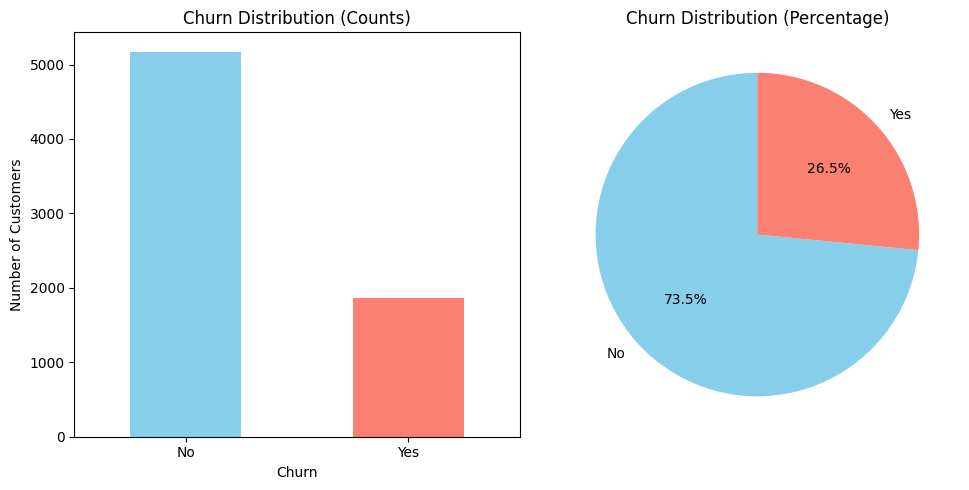

In [15]:
# Visualize target variable distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution (Counts)')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'], startangle=90)
plt.title('Churn Distribution (Percentage)')

plt.tight_layout()
plt.show()

### 5. Feature Categories Analysis

In [16]:
# Categorize features based on Telco domain knowledge
demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
account_features = ['tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod']
service_features = ['PhoneService', 'MultipleLines', 'InternetService', 
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
financial_features = ['MonthlyCharges', 'TotalCharges']

print("Feature Categories:")
print(f"Demographic features ({len(demographic_features)}): {demographic_features}")
print(f"Account features ({len(account_features)}): {account_features}")
print(f"Service features ({len(service_features)}): {service_features}")
print(f"Financial features ({len(financial_features)}): {financial_features}")

Feature Categories:
Demographic features (4): ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
Account features (4): ['tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Service features (9): ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Financial features (2): ['MonthlyCharges', 'TotalCharges']


In [17]:
# Identify categorical and numerical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Churn')  # Remove target variable

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

Categorical features (17): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
Numerical features (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']


### 6. Basic Statistical Summary

In [18]:
# Statistical summary for numerical features
print("Statistical Summary - Numerical Features:")
df[numerical_features].describe()

Statistical Summary - Numerical Features:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [19]:
# Summary for categorical features
print("Categorical Features Summary:")
for feature in categorical_features:
    unique_count = df[feature].nunique()
    unique_values = df[feature].unique()[:10]  # Show first 10 unique values
    print(f"\n{feature}:")
    print(f"  Unique values: {unique_count}")
    print(f"  Sample values: {unique_values}")
    if unique_count <= 10:
        print(f"  Value counts:\n{df[feature].value_counts()}")

Categorical Features Summary:

customerID:
  Unique values: 7043
  Sample values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU'
 '9305-CDSKC' '1452-KIOVK' '6713-OKOMC' '7892-POOKP' '6388-TABGU']

gender:
  Unique values: 2
  Sample values: ['Female' 'Male']
  Value counts:
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner:
  Unique values: 2
  Sample values: ['Yes' 'No']
  Value counts:
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents:
  Unique values: 2
  Sample values: ['No' 'Yes']
  Value counts:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService:
  Unique values: 2
  Sample values: ['No' 'Yes']
  Value counts:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines:
  Unique values: 3
  Sample values: ['No phone service' 'No' 'Yes']
  Value counts:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetServ

### 7. Data Quality Issues Identification

In [20]:
# Check for inconsistencies in categorical data
print("Data Quality Issues Summary:")
print("=" * 40)

# 1. Check TotalCharges data type issue
if df['TotalCharges'].dtype == 'object':
    print("\n1. TotalCharges Data Type Issue:")
    non_numeric_mask = pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()
    non_numeric_count = non_numeric_mask.sum()
    print(f"   - Found {non_numeric_count} non-numeric values in TotalCharges")
    if non_numeric_count > 0:
        print(f"   - Non-numeric values: {df[non_numeric_mask]['TotalCharges'].unique()}")

# 2. Check for impossible combinations
print("\n2. Business Logic Issues:")
# Customers with 0 tenure but have TotalCharges
zero_tenure = df[df['tenure'] == 0]
print(f"   - Customers with 0 tenure: {len(zero_tenure)}")
if len(zero_tenure) > 0:
    print(f"   - Their TotalCharges range: {zero_tenure['TotalCharges'].describe()}")

# 3. Check service dependencies
print("\n3. Service Dependencies:")
no_internet = df[df['InternetService'] == 'No']
internet_dependent_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                              'TechSupport', 'StreamingTV', 'StreamingMovies']
for service in internet_dependent_services:
    invalid_count = len(no_internet[no_internet[service] != 'No internet service'])
    if invalid_count > 0:
        print(f"   - {service}: {invalid_count} customers without internet but have this service")

Data Quality Issues Summary:

1. TotalCharges Data Type Issue:
   - Found 11 non-numeric values in TotalCharges
   - Non-numeric values: [' ']

2. Business Logic Issues:
   - Customers with 0 tenure: 11
   - Their TotalCharges range: count     11
unique     1
top         
freq      11
Name: TotalCharges, dtype: object

3. Service Dependencies:


### 8. Initial Data Cleaning

In [21]:
# Create a copy for cleaning
df_clean = df.copy()

print("Initial Data Cleaning Steps:")
print("=" * 30)

# 1. Fix TotalCharges data type
if df_clean['TotalCharges'].dtype == 'object':
    print("\n1. Converting TotalCharges to numeric...")
    # Convert to numeric, marking non-numeric as NaN
    df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
    print(f"   - Converted TotalCharges to numeric type")
    print(f"   - Created {df_clean['TotalCharges'].isnull().sum()} NaN values from non-numeric entries")

# 2. Check data shape after cleaning
print(f"\n2. Dataset shape after initial cleaning: {df_clean.shape}")

# 3. Update feature lists
numerical_features_updated = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_updated = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_features_updated.remove('Churn')  # Remove target

print(f"\n3. Updated feature counts:")
print(f"   - Numerical features: {len(numerical_features_updated)}")
print(f"   - Categorical features: {len(categorical_features_updated)}")

Initial Data Cleaning Steps:

1. Converting TotalCharges to numeric...
   - Converted TotalCharges to numeric type
   - Created 11 NaN values from non-numeric entries

2. Dataset shape after initial cleaning: (7043, 21)

3. Updated feature counts:
   - Numerical features: 4
   - Categorical features: 16


### 9. Save Prepared Data

In [29]:
# Ensure processed directory exists
os.makedirs('D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\data\processed', exist_ok=True)

# Save the initially cleaned dataset
output_file = 'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\data\processed/telco_data_prepared.csv'
df_clean.to_csv(output_file, index=False)

print(f"Data preparation completed!")
print(f"Cleaned dataset saved to: {output_file}")
print(f"Dataset shape: {df_clean.shape}")
print(f"Ready for exploratory data analysis...")

Data preparation completed!
Cleaned dataset saved to: D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\data\processed/telco_data_prepared.csv
Dataset shape: (7043, 21)
Ready for exploratory data analysis...


### 10. Data Preparation Summary

In [24]:
print("DATA PREPARATION SUMMARY")
print("=" * 50)
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Features analyzed: {df.shape[1]}")
print(f"Target variable: Churn (Class imbalance: {imbalance_ratio:.1f}:1)")
print(f"\nFeature Categories:")
print(f"- Demographic: {len(demographic_features)} features")
print(f"- Account: {len(account_features)} features")
print(f"- Services: {len(service_features)} features")
print(f"- Financial: {len(financial_features)} features")
print(f"\nData Quality Issues Identified:")
if df['TotalCharges'].dtype == 'object':
    print(f"- TotalCharges data type issue (fixed)")
print(f"- Missing values to handle in next steps")
print(f"- Class imbalance to address in modeling")
print(f"\nNext Steps:")
print(f"1. Comprehensive EDA (notebook 1)")
print(f"2. Feature engineering (notebook 2)")
print(f"3. Missing value handling")
print(f"4. Model development and ensemble methods")

DATA PREPARATION SUMMARY
Original dataset shape: (7043, 21)
Cleaned dataset shape: (7043, 21)
Features analyzed: 21
Target variable: Churn (Class imbalance: 2.8:1)

Feature Categories:
- Demographic: 4 features
- Account: 4 features
- Services: 9 features
- Financial: 2 features

Data Quality Issues Identified:
- TotalCharges data type issue (fixed)
- Missing values to handle in next steps
- Class imbalance to address in modeling

Next Steps:
1. Comprehensive EDA (notebook 1)
2. Feature engineering (notebook 2)
3. Missing value handling
4. Model development and ensemble methods
